In [1]:
from utils.ZR_utils import (get_matches_df, post_disc, plot_match_stats, change_post_disc_thr,
                            get_nodes_df, get_clusters_list, get_matches_all)
from utils.eval import evaluate
from utils.helper_fncs import save_obj, load_obj

from utils.db_utils import gold_fragments_df_for_signer
from utils.feature_utils import (op_100_meancenter)

import glob
import pandas as pd
import numpy as np
import os

In [2]:
import matplotlib.pyplot as plt


label_dict = {'coverage': 'Coverage',
                'ned':'NED', 
              'purity': 'Purity',
              'avg_purity': 'Average Purity', 
              'clus_purity':'Cluster Purity', 
              'grouping_P': 'Grouping Precision',
              'grouping_R': 'Grouping Recall',
                'grouping_F': 'Grouping F-score',
              'clus_purity_inv': 'Inverse Cluster Purity'}

def slct_res(res,sel):
    tmp = []
    for i, r in enumerate(res):
        if i not in sel: tmp.append(r)
    return tmp


def plot_curve(ax, results, ax_dict, marker, label, annot_freq=2):
    # results: list of score dicts
    data = np.zeros((len(results), 2))
    annots = []
    for i,score in enumerate(results):
        data[i,0] = score[ax_dict['x']]
        data[i,1] = score[ax_dict['y']]
        annots.append(score['dtw'])

    ax.plot(data[:,0], data[:,1], marker, label=label)
    ax.set_xlabel(label_dict[ax_dict['x']])
    ax.set_ylabel(label_dict[ax_dict['y']])
    for i,ann in enumerate(annots):
        
        if (i%annot_freq != 0) or (annot_freq==-1): continue
        ax.annotate(str(ann), 
             xy=(results[i][ax_dict['x']], results[i][ax_dict['y']]),  
             xycoords='data')

In [3]:
exp_root = '/home/korhan/Desktop/zerospeech2017/track2/src/ZRTools/exp/'

exp_ = 'corAE_op100_s4s5_64_iter0_self_tanh_Signer07'
#exp_ = 'Signer01_Signer08_c3_right_PCA50_10_3_02_7_05_055_11_06_03'
#exp_ = 'corAE_op100_s4s5_64_iter0_self_tanh_Signer01'
#exp_ = 'corAE_op100_s4s5_64_iter0_self_tanh_Signer04_Signer05_Signer0950_10_35_02_7_05_06_9_06_032'
#exp_ = 'corAE_op100_s4s5_64_iter0_self_tanh_Signer01_Signer0850_10_4_02_7_05_06_7_06_032'
#exp_ = 'Signer07op10050_10_5_02_7_05_065_13_06_04'
#exp_ = 'corAE_op100_s4s5_64_iter0_self_tanhSigner0350_10_4_02_7_05_06_9_06_03'
#exp_ = 'Signer03_Signer07_c3_right_PCA50_10_3_02_7_05_055_11_06_03'
exp_ = 'Signer03_c3_right_PCA50_10_3_02_7_05_06_13_06_04'
#exp_ = 'op100_Signer03_Signer0750_10_4_02_7_05_06_9_06_03'
#exp_ = 'corAE_op100_s4s5_64_iter0_self_tanh_Signer03_Signer0750_10_4_02_7_05_06_9_06_032'
#exp_ = 'op100_Signer08'
#exp_ = 'corAE_op100_s4s5_64_iter0_self_tanh_Signer0450_10_4_02_7_05_06_7_06_032'

signer_id = ['Signer0'+ str(i) for i in [8]]
#signer_id = ['Signer0'+ str(i) for i in [3,7]]
signer_id = ['Signer0'+ str(i) for i in [3]]

print(signer_id)

def full_exp_path(exp_):
    exp_root = '/home/korhan/Desktop/zerospeech2017/track2/src/ZRTools/exp/'

    try:
        name_root = glob.glob(exp_root + 'zrroot0_{}*/exp/*'.format(exp_))[0]
        exp_name = '/'.join(name_root.split('/')[-3:])[:-6]
    except:
        name_root = glob.glob(exp_root + '{}*/'.format(exp_))[0]
        exp_name = glob.glob(exp_root + '{}*/'.format(exp_))[0].split('/')[-2][:-6]
    
    return name_root, exp_name
    
print(exp_name)


['Signer03']


NameError: name 'exp_name' is not defined

In [37]:
matches_df = get_matches_all(exp_name)
matches_df.head()

Read 26 matches
Read 17 matches
Read 14 matches
Read 23 matches
Read 32 matches
Read 18 matches
Read 0 matches
Read 0 matches
Read 15 matches
Read 16 matches
Read 24 matches
Read 36 matches
Read 23 matches
Read 21 matches
Read 22 matches
Read 26 matches


,f1,f2,f1_start,f1_end,f2_start,f2_end,score,rho
0,22April_2010_Thursday_heute_default-0,29April_2010_Thursday_heute_default-0,10,35,14,39,0.918155,3.789952
1,11February_2010_Thursday_tagesschau_default-9,12January_2010_Tuesday_heute_default-9,20,55,114,147,0.928610,25.081400
2,11February_2010_Thursday_tagesschau_default-9,06April_2010_Tuesday_heute_default-6,17,58,112,146,0.926288,31.536909
3,11February_2010_Thursday_tagesschau_default-9,20July_2010_Tuesday_heute_default-12,33,59,10,36,0.908951,6.039716
4,11February_2010_Thursday_tagesschau_default-9,10January_2010_Sunday_tagesschau_default-12,17,52,83,111,0.915518,6.031500


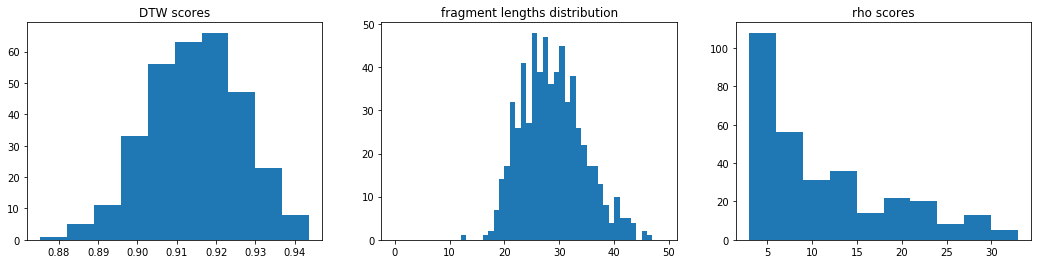

In [38]:
plot_match_stats(matches_df)

In [40]:

results = []
#for dtw in np.arange(0.89,0.98,0.01):
for dtw in [0.91]:
    print(dtw)

    results_path = post_disc(exp_name, dtw)

    " get nodes "
    nodes_df = get_nodes_df(exp_name)

    " get clusters "
    clusters_list = get_clusters_list(exp_name)
    if len(clusters_list)==0: continue
    
    scores = evaluate(None, signer_id, matches_df, nodes_df, clusters_list,
                      group=3, interp=False, boundary_th=0.5, fast_compute=True, purify=True)

    scores['dtw'] = dtw
    scores['exp'] = exp_name
    
    results.append(scores)


0.91
./post_disc Signer03_c3_right_PCA50_10_3_02_7_05_06_13_06_04.lsh64 0.91
Read 406 nodes/tokens
Read 60 clusters


In [41]:
scores

OrderedDict([('n_match', 313),
             ('n_node', 99),
             ('n_clus', 27),
             ('mean_len', 29.818181818181817),
             ('mean_n_type', 2.0707070707070705),
             ('ned', 0.54072598494909219),
             ('coverage', 0.059437358882040645),
             ('matching_P', 0),
             ('matching_R', 0),
             ('matching_F', 0),
             ('purity', 0.55169996494917628),
             ('inv_purity', 0.72485103399929895),
             ('garbage_ratio', 0.069751139151770072),
             ('avg_purity', 0.7474747474747475),
             ('clus_purity', 0.51515151515151514),
             ('clus_purity_inv', 0.93939393939393945),
             ('grouping_P', 0.5555555555555556),
             ('grouping_R', 0.859375),
             ('grouping_F', 0.6748466257668713),
             ('type_P', 0.4),
             ('type_R', 0.015384615384615385),
             ('type_F', 0.02962962962962963),
             ('dtw', 0.91),
             ('exp', 'Signer03_c3

In [11]:
results

[OrderedDict([('n_match', 113137),
              ('n_node', 4),
              ('n_clus', 2),
              ('mean_len', 14.5),
              ('mean_n_type', 1.0),
              ('ned', 0.5),
              ('coverage', 0.00065893366355756014),
              ('matching_P', 0),
              ('matching_R', 0),
              ('matching_F', 0),
              ('purity', 0.68518518518518523),
              ('inv_purity', 0.81481481481481477),
              ('garbage_ratio', 0.18518518518518517),
              ('avg_purity', 0.75),
              ('clus_purity', 0.75),
              ('clus_purity_inv', 1.0),
              ('grouping_P', 0.5),
              ('grouping_R', 1.0),
              ('grouping_F', 0.6666666666666666),
              ('type_P', 1.0),
              ('type_R', 0.002898550724637681),
              ('type_F', 0.005780346820809248),
              ('dtw', 0.89000000000000001),
              ('exp',
               'zrroot0_corAE_op100_s4s5_64_iter0_self_tanh_Signer0450_10_4_02_7

In [7]:
resname = 'train_set'
final = load_obj(name='grid_post_disc_' + resname, path='/home/korhan/Dropbox/tez/files/ZR_dtw_curves')
final['AE (Signer04)2'] = results


In [86]:
final = dict()
resname = 'train_set'
final['AE (Signer04 Signer05 Signer09)'] = results

In [8]:
save_obj(obj=final, name='grid_post_disc_' + resname, path='/home/korhan/Dropbox/tez/files/ZR_dtw_curves' )

In [373]:
resname = 'test_set'
final = load_obj(name='grid_post_disc_' + resname, path='/home/korhan/Dropbox/tez/files/ZR_dtw_curves')

In [475]:
results

[OrderedDict([('n_match', 178351),
              ('n_node', 4738),
              ('n_clus', 2231),
              ('mean_len', 23.992401857323767),
              ('mean_n_type', 1.7566483748417054),
              ('ned', 0.87164124293785372),
              ('coverage', 0.35238360878938013),
              ('matching_P', 0),
              ('matching_R', 0),
              ('matching_F', 0),
              ('purity', 0.37800400227652425),
              ('inv_purity', 0.072995648901209867),
              ('garbage_ratio', 0.17223558354293267),
              ('avg_purity', 0.5588856057408189),
              ('clus_purity', 0.50042211903756861),
              ('clus_purity_inv', 0.47952722667792319),
              ('grouping_P', 0.05107640354579992),
              ('grouping_R', 0.09456819069949199),
              ('grouping_F', 0.06632862820337125),
              ('type_P', 0.4878048780487805),
              ('type_R', 0.075046904315197),
              ('type_F', 0.13008130081300814),
        

In [331]:
results.extend(final['AE (Signer01)'])

In [333]:
final['AE (Signer01)'] = results

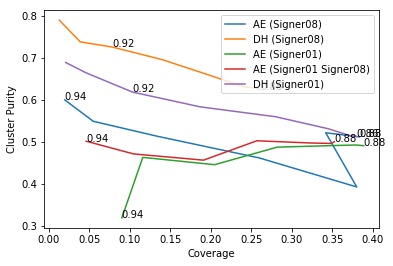

In [238]:
fig, axes = plt.subplots(1,1,squeeze=False)
for ky, res in final.items():
    plot_curve(axes[0,0], res, {'x': 'coverage', 'y': 'clus_purity'}, label=ky, annot_freq=6)
plt.legend()

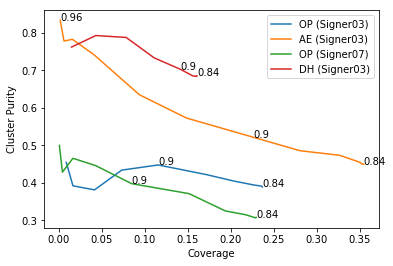

In [271]:
fig, axes = plt.subplots(1,1,squeeze=False)
for ky, res in final.items():
    plot_curve(axes[0,0], res, {'x': 'coverage', 'y': 'clus_purity'}, label=ky, annot_freq=6)
plt.legend()

In [21]:
res

[OrderedDict([('n_match', 113137),
              ('n_node', 78),
              ('n_clus', 37),
              ('mean_len', 18.102564102564102),
              ('mean_n_type', 1.1923076923076923),
              ('ned', 0.67907801418439706),
              ('coverage', 0.015837129775848946),
              ('matching_P', 0),
              ('matching_R', 0),
              ('matching_F', 0),
              ('purity', 0.54947526236881561),
              ('inv_purity', 0.63493253373313341),
              ('garbage_ratio', 0.10869565217391304),
              ('avg_purity', 0.6538461538461539),
              ('clus_purity', 0.62820512820512819),
              ('clus_purity_inv', 0.74358974358974361),
              ('grouping_P', 0.19230769230769232),
              ('grouping_R', 0.35714285714285715),
              ('grouping_F', 0.25000000000000006),
              ('type_P', 0.7777777777777778),
              ('type_R', 0.020289855072463767),
              ('type_F', 0.03954802259887005),
         

In [9]:
resname = 'train_set'
train = load_obj(name='grid_post_disc_' + resname, path='/home/korhan/Dropbox/tez/files/ZR_dtw_curves')
train.keys()

['AE (Signer04 Signer05 Signer09)', 'AE (Signer04)', 'AE (Signer04)2']

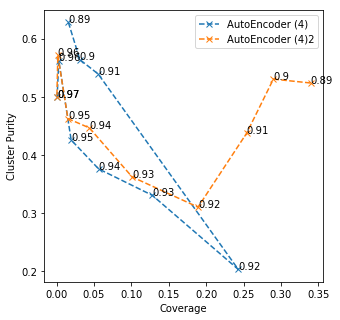

In [13]:
%matplotlib inline
tmp = train
ax_dict = {'x': 'coverage', 'y': 'clus_purity'}
fig, axes = plt.subplots(1,1,squeeze=False, figsize=(5,5))


ky = 'AE (Signer04)'
res = tmp[ky]
lb = 'AutoEncoder (4)'
plot_curve(axes[0,0], slct_res(res[:],[]), ax_dict, '--x', label=lb, annot_freq=1)


ky = 'AE (Signer04)2'
res = tmp[ky]
lb = 'AutoEncoder (4)2'
plot_curve(axes[0,0], slct_res(res[:],[]), ax_dict, '--x', label=lb, annot_freq=1)

"""ky = 'AE (Signer05)'
res = tmp[ky]
lb = 'AutoEncoder (5)'
plot_curve(axes[0,0], slct_res(res[:],[]), ax_dict, '--x', label=lb, annot_freq=1)
"""


plt.legend()

In [17]:
resname = 'test_set'
test = load_obj(name='grid_post_disc_' + resname, path='/home/korhan/Dropbox/tez/files/ZR_dtw_curves')
test.keys()

['AE (Signer08)',
 'AE (Signer01,Signer08)',
 'DH (Signer01,Signer08)',
 'AE (Signer01 Signer08)',
 'AE (Signer01,Signer08)3',
 'AE (Signer01,Signer08)2',
 'DH (Signer08)',
 'AE (Signer01)',
 'OP (Signer08)',
 'OP (Signer01,Signer08)',
 'DH (Signer01)']

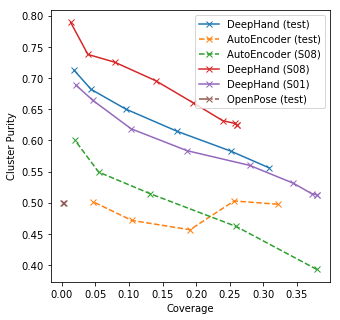

In [108]:
%matplotlib inline
tmp = test
ax_dict = {'x': 'coverage', 'y': 'clus_purity'}
fig, axes = plt.subplots(1,1,squeeze=False, figsize=(5,5))

ky = 'DH (Signer01,Signer08)'
res = tmp[ky]
lb = 'DeepHand (test)'
plot_curve(axes[0,0], res[:-2], ax_dict, '-x', label=lb, annot_freq=-1)

ky = 'AE (Signer01,Signer08)'
res = tmp[ky]
lb = 'AutoEncoder (test)'
plot_curve(axes[0,0], slct_res(res[2:-4],[]), ax_dict, '--x', label=lb, annot_freq=-1)

ky = 'AE (Signer08)'
res = tmp[ky]
lb = 'AutoEncoder (S08)'
plot_curve(axes[0,0], slct_res(res[2:],[]), ax_dict, '--x', label=lb, annot_freq=-1)

ky = 'DH (Signer08)'
res = tmp[ky]
lb = 'DeepHand (S08)'
plot_curve(axes[0,0], slct_res(res[:],[]), ax_dict, '-x', label=lb, annot_freq=-1)

ky = 'DH (Signer01)'
res = tmp[ky]
lb = 'DeepHand (S01)'
plot_curve(axes[0,0], slct_res(res[:],[]), ax_dict, '-x', label=lb, annot_freq=-1)

ky = 'OP (Signer01,Signer08)'
res = tmp[ky]
lb = 'OpenPose (test)'
plot_curve(axes[0,0], res[6:], ax_dict, '-.x', label=lb, annot_freq=-1)


plt.legend()

In [4]:
resname = 'dev_set'
dev = load_obj(name='grid_post_disc_' + resname, path='/home/korhan/Dropbox/tez/files/ZR_dtw_curves')
dev.keys()

['AE (Signer03,Signer07)', 'OP (Signer03,Signer07)', 'DH (Signer03,Signer07)']

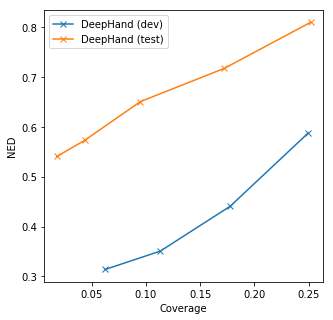

In [21]:
tmp = dev
ax_dict = {'x': 'coverage', 'y': 'ned'}
fig, axes = plt.subplots(1,1,squeeze=False, figsize=(5,5))

ky = 'DH (Signer03,Signer07)'
res = tmp[ky]
lb = 'DeepHand (dev)'
plot_curve(axes[0,0], res[4:-3], ax_dict, '-x', label=lb, annot_freq=-1)


ky = 'DH (Signer01,Signer08)'
res = test[ky]
lb = 'DeepHand (test)'
plot_curve(axes[0,0], res[1:-2], ax_dict, '-x', label=lb, annot_freq=-1)


"""ky = 'AE (Signer03,Signer07)'
res = tmp[ky]
lb = 'AutoEncoder (dev)'
plot_curve(axes[0,0], res[4:-2], ax_dict, '--x', label=lb, annot_freq=-1)
"""
"""ky = 'OP (Signer03,Signer07)'
res = tmp[ky]
lb = 'OpenPose (dev)'
plot_curve(axes[0,0], res[6:], ax_dict, '-.x', label=lb, annot_freq=-1)
"""

plt.legend()

In [12]:
cost_thr = 0.20

cost_val = matches_df.score.sort_values(ascending=False).values[round(len(matches_df) * cost_thr)]
print(cost_val)

0.900323


/home/korhan/anaconda3/envs/zerospeech/lib/python2.7/site-packages/ipykernel_launcher.py:3: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  This is separate from the ipykernel package so we can avoid doing imports until


In [176]:
#cost_val = 0.90
results_path = post_disc(exp_name, cost_val)

" get nodes "
nodes_df = get_nodes_df(exp_name)

" get clusters "
clusters_list = get_clusters_list(exp_name)

scores = evaluate(None, signer_id, matches_df, nodes_df, clusters_list,
                  group=3, interp=False, boundary_th=0.5, fast_compute=False)

scores['exp'] = exp_name

./post_disc zrroot0_corAE_op100_s4s5_64_iter0_self_tanh_Signer01_Signer0850_10_35_02_7_05_06_9_06_032/exp/corAE_op100_s4s5_64_iter0_self_tanh_Signer01_Signer0850_10_35_02_7_05_06_9_06_032.lsh64 0.909653
Read 106968 nodes/tokens
Read 1703 clusters
38.3903647006% OVERLAP


In [177]:
scores

OrderedDict([('n_match', 178351),
             ('n_node', 3742),
             ('n_clus', 1703),
             ('mean_len', 23.741314804917156),
             ('mean_n_type', 1.7014965259219668),
             ('ned', 0.83056896978702366),
             ('coverage', 0.25875534208237205),
             ('matching_P', 0.14544741742624717),
             ('matching_R', 0.03261681832168447),
             ('matching_F', 0.053284501175921435),
             ('purity', 0.41049143340619049),
             ('inv_purity', 0.087863404545347717),
             ('garbage_ratio', 0.14634891536816377),
             ('avg_purity', 0.5611972207375735),
             ('clus_purity', 0.50347407803313737),
             ('clus_purity_inv', 0.43639764831640832),
             ('grouping_P', 0.07856761090326028),
             ('grouping_R', 0.13486238532110092),
             ('grouping_F', 0.09929078014184396),
             ('type_P', 0.582089552238806),
             ('type_R', 0.07317073170731707),
             ('type_

In [145]:
import pandas as pd

select = ['exp','n_clus','n_node','coverage',
          'matching_P','matching_R','matching_F',
          'grouping_P','grouping_R','grouping_F',
          'clus_purity', 'clus_purity_inv']

pd.DataFrame([scores], columns=scores.keys())[select]

,exp,n_clus,n_node,coverage,matching_P,matching_R,matching_F,grouping_P,grouping_R,grouping_F,clus_purity,clus_purity_inv
0,zrroot0_Signer01_Signer08_c3_right_PCA50_10_3_...,432,1086,0.084741,0.319031,0.024023,0.044682,0.407919,0.593039,0.483361,0.617864,0.502762


In [146]:
nodes_df

,filename,start,end,score,unknown,file_id
1,26June_2010_Saturday_tagesschau_default-2,72,98,0.921689,4.670115,1775
2,03July_2010_Saturday_tagesschau_default-14,103,128,0.921689,4.670115,156
3,26June_2010_Saturday_tagesschau_default-2,74,98,0.915857,3.789952,1775
4,25October_2010_Monday_tagesschau_default-4,158,184,0.915857,3.789952,1726
5,26June_2010_Saturday_tagesschau_default-2,78,98,0.924372,3.391010,1775
6,10August_2009_Monday_heute_default-11,101,123,0.924372,3.391010,685
7,26June_2010_Saturday_tagesschau_default-0,29,66,0.920092,23.872665,1769
8,05December_2009_Saturday_tagesschau_default-0,36,70,0.920092,23.872665,240
9,26June_2010_Saturday_tagesschau_default-0,18,50,0.903186,8.026211,1769
10,09August_2009_Sunday_tagesschau_default-0,14,41,0.903186,8.026211,589


In [181]:
from utils.db_utils import nodes_with_info, gold_fragments_df_for_signer, nodes_with_types

clusters_set = set()
for row in clusters_list: clusters_set |= set(row)
all_centroids = list(clusters_set)


# select only nodes that belong to a cluster (dedups?)
nodes_df = nodes_df.loc[all_centroids]

gold_fragments = gold_fragments_df_for_signer(signer_id)

nodes_df = nodes_with_info(nodes_df=nodes_df, gold_fragments=gold_fragments)

nodes_df = nodes_with_types(nodes_df=nodes_df, gold_fragments=gold_fragments)

for clus in clusters_list:
    n_signer_different = len(nodes_df.signer_id[clus].unique())
    if n_signer_different>1:
        print(clus,n_signer_different)

In [1]:
for clus in clusters_list:
    n_signer_different = len(nodes_df.signer_id[clus].unique())
    if n_signer_different>1:
        print(clus,n_signer_different)

NameError: name 'clusters_list' is not defined

In [182]:
nodes_df

,filename,start,end,score,unknown,file_id
24576,02June_2010_Wednesday_tagesschau_default-3,3,39,0.914838,28.765520,100
32769,30May_2010_Sunday_tagesschau_default-0,40,106,0.960022,53.500641,2085
32770,05July_2010_Monday_tagesschau_default-19,2,71,0.960022,53.500641,321
24579,26October_2010_Tuesday_tagesschau_default-8,14,44,0.922156,14.963890,1796
24580,20March_2010_Saturday_heute_default-10,47,85,0.922156,14.963890,1341
57345,24June_2010_Thursday_tagesschau_default-17,105,135,0.917187,8.719263,1643
90120,11August_2011_Thursday_heute_default-6,39,66,0.915549,7.518915,780
57355,24June_2010_Thursday_tagesschau_default-17,52,78,0.912963,2.194183,1643
57356,06May_2011_Friday_tagesschau_default-16,26,51,0.912963,2.194183,424
57346,07August_2009_Friday_tagesschau_default-13,12,28,0.917187,8.719263,487


In [91]:
nodes

NameError: name 'nodes' is not defined

In [49]:
change_post_disc_thr(olapthr=0.9, dedupthr=0.2, durthr=5, rhothr=1000, min_edge_w=0)

'zrroot0_corAE_op100_s4s5_64_iter0_self_tanh_Signer01_Signer0850_10_4_02_7_05_06_7_06_032/exp/corAE_op100_s4s5_64_iter0_self_tanh_Signer01_Signer0850_10_4_02_7_05_06_7_06_032'

In [ ]:
# 0.9 0.2 0

In [31]:
#results = []
for olap in [ 0.3]:
    for dedup in [0.5]:
        for th in [600, 800]:
            change_post_disc_thr(olapthr=olap, dedupthr=dedup, durthr=5, rhothr=1000, min_edge_w=th)

            print('olap {}, dedup {}'.format(olap, dedup))

            results_path = post_disc(exp_name, dtw)

            " get nodes "
            nodes_df = get_nodes_df(exp_name)

            " get clusters "
            clusters_list = get_clusters_list(exp_name)
            if len(clusters_list)==0: continue

            scores = evaluate(None, signer_id, matches_df, nodes_df, clusters_list,
                              group=3, interp=False, boundary_th=0.5, fast_compute=True)

            scores['dtw'] = dtw
            scores['exp'] = exp_name
            scores['olap'] = olap
            scores['dedup'] = dedup
            scores['th'] = th

            results.append(scores)

olap 0.3, dedup 0.5
./post_disc zrroot0_corAE_op100_s4s5_64_iter0_self_tanh_Signer0450_10_4_02_7_05_06_7_06_032/exp/corAE_op100_s4s5_64_iter0_self_tanh_Signer0450_10_4_02_7_05_06_7_06_032.lsh64 0.9
Read 46404 nodes/tokens
Read 144 clusters
olap 0.3, dedup 0.5
./post_disc zrroot0_corAE_op100_s4s5_64_iter0_self_tanh_Signer0450_10_4_02_7_05_06_7_06_032/exp/corAE_op100_s4s5_64_iter0_self_tanh_Signer0450_10_4_02_7_05_06_7_06_032.lsh64 0.9
Read 46404 nodes/tokens
Read 449 clusters
15.8854289348% OVERLAP


In [53]:
results[0].keys()

['n_match',
 'n_node',
 'n_clus',
 'mean_len',
 'mean_n_type',
 'ned',
 'coverage',
 'matching_P',
 'matching_R',
 'matching_F',
 'purity',
 'inv_purity',
 'garbage_ratio',
 'avg_purity',
 'clus_purity',
 'clus_purity_inv',
 'grouping_P',
 'grouping_R',
 'grouping_F',
 'type_P',
 'type_R',
 'type_F',
 'dtw',
 'exp',
 'olap',
 'dedup']

In [32]:
pd.DataFrame.from_records(results)[['mean_len','n_node','n_clus','ned','coverage','olap','dedup','th']]

,mean_len,n_node,n_clus,ned,coverage,olap,dedup,th
0,18.012821,156,76,0.809524,0.031197,0.30,0.2,NaN
1,17.993671,158,76,0.803371,0.031254,0.30,0.7,NaN
2,18.479042,167,76,0.694915,0.031583,0.30,0.9,NaN
3,22.257898,3672,1665,0.821376,0.490394,0.90,0.2,NaN
4,22.271196,3680,1665,0.817960,0.490735,0.90,0.7,NaN
5,22.369338,3731,1665,0.792499,0.490860,0.90,0.9,NaN
6,25.212441,24162,9906,0.902595,0.718726,0.98,0.2,NaN
7,25.221296,24221,9906,0.901972,0.718794,0.98,0.7,NaN
8,25.239221,24329,9906,0.898757,0.718794,0.98,0.9,NaN
9,18.479042,167,76,0.694915,0.031583,0.30,0.9,0.0
